# Credit_default_prediction_setup_project

Tabular dataset classification with deep learning

## Startup cells

In [0]:
# Set environment variables for sagemaker_studio imports

import os
os.environ['DataZoneProjectId'] = 'cgk5ugdebva2ef'
os.environ['DataZoneDomainId'] = 'dzd-bsa8pqfbpcm7on'
os.environ['DataZoneEnvironmentId'] = 'cbebxulwrbe6g7'
os.environ['DataZoneDomainRegion'] = 'us-east-1'

# create both a function and variable for metadata access
_resource_metadata = None

def _get_resource_metadata():
    global _resource_metadata
    if _resource_metadata is None:
        _resource_metadata = {
            "AdditionalMetadata": {
                "DataZoneProjectId": "cgk5ugdebva2ef",
                "DataZoneDomainId": "dzd-bsa8pqfbpcm7on",
                "DataZoneEnvironmentId": "cbebxulwrbe6g7",
                "DataZoneDomainRegion": "us-east-1",
            }
        }
    return _resource_metadata
metadata = _get_resource_metadata()

In [0]:
"""
Logging Configuration

Purpose:
--------
This sets up the logging framework for code executed in the user namespace.
"""

from typing import Optional


def _set_logging(log_dir: str, log_file: str, log_name: Optional[str] = None):
    import os
    import logging
    from logging.handlers import RotatingFileHandler

    level = logging.INFO
    max_bytes = 5 * 1024 * 1024
    backup_count = 5

    # fallback to /tmp dir on access, helpful for local dev setup
    try:
        os.makedirs(log_dir, exist_ok=True)
    except Exception:
        log_dir = "/tmp/kernels/"

    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, log_file)

    logger = logging.getLogger() if not log_name else logging.getLogger(log_name)
    logger.handlers = []
    logger.setLevel(level)

    formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

    # Rotating file handler
    fh = RotatingFileHandler(filename=log_path, maxBytes=max_bytes, backupCount=backup_count, encoding="utf-8")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    logger.info(f"Logging initialized for {log_name}.")


_set_logging("/var/log/computeEnvironments/kernel/", "kernel.log")
_set_logging("/var/log/studio/data-notebook-kernel-server/", "metrics.log", "metrics")

In [0]:
import logging
from sagemaker_studio import ClientConfig, sqlutils, sparkutils, dataframeutils

logger = logging.getLogger(__name__)
logger.info("Initializing sparkutils")
spark = sparkutils.init()
logger.info("Finished initializing sparkutils")

In [0]:
def _reset_os_path():
    """
    Reset the process's working directory to handle mount timing issues.
    
    This function resolves a race condition where the Python process starts
    before the filesystem mount is complete, causing the process to reference
    old mount paths and inodes. By explicitly changing to the mounted directory
    (/home/sagemaker-user), we ensure the process uses the correct, up-to-date
    mount point.
    
    The function logs stat information (device ID and inode) before and after
    the directory change to verify that the working directory is properly
    updated to reference the new mount.
    
    Note:
        This is executed at module import time to ensure the fix is applied
        as early as possible in the kernel initialization process.
    """
    try:
        import os
        import logging

        logger = logging.getLogger(__name__)
        logger.info("---------Before------")
        logger.info("CWD: %s", os.getcwd())
        logger.info("stat('.'): %s %s", os.stat('.').st_dev, os.stat('.').st_ino)
        logger.info("stat('/home/sagemaker-user'): %s %s", os.stat('/home/sagemaker-user').st_dev, os.stat('/home/sagemaker-user').st_ino)

        os.chdir("/home/sagemaker-user")

        logger.info("---------After------")
        logger.info("CWD: %s", os.getcwd())
        logger.info("stat('.'): %s %s", os.stat('.').st_dev, os.stat('.').st_ino)
        logger.info("stat('/home/sagemaker-user'): %s %s", os.stat('/home/sagemaker-user').st_dev, os.stat('/home/sagemaker-user').st_ino)
    except Exception as e:
        logger.exception(f"Failed to reset working directory: {e}")

_reset_os_path()

## Notebook

In [0]:
import os

BASE_DIR = "/home/sagemaker-user/mle-deep-learning-project"

folders = [
    "data/raw",
    "data/processed",
    "notebooks",
    "src",
    "models/checkpoints"
]

for folder in folders:
    path = os.path.join(BASE_DIR, folder)
    os.makedirs(path, exist_ok=True)
    print(f"Created: {path}")


Created: /home/sagemaker-user/mle-deep-learning-project/data/raw
Created: /home/sagemaker-user/mle-deep-learning-project/data/processed
Created: /home/sagemaker-user/mle-deep-learning-project/notebooks
Created: /home/sagemaker-user/mle-deep-learning-project/src
Created: /home/sagemaker-user/mle-deep-learning-project/models/checkpoints


In [0]:
import os

PROJECT_ROOT = "/home/sagemaker-user/mle-deep-learning-project"
NOTEBOOK_DIR = os.getcwd()

print("Notebook running from:", NOTEBOOK_DIR)
print("Project root exists:", os.path.exists(PROJECT_ROOT))

assert os.path.exists(PROJECT_ROOT), "Project folder missing"
print("\nThis notebook will be used as the MAIN training notebook ✅")



Notebook running from: /home/sagemaker-user
Project root exists: True

This notebook will be used as the MAIN training notebook ✅


In [0]:
import sys
import subprocess

# Install MLflow
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "mlflow"])

# Verify installation
import mlflow

print("MLflow version:", mlflow.__version__)

# Quick sanity test
with mlflow.start_run():
    mlflow.log_param("test_param", 1)
    mlflow.log_metric("test_metric", 0.99)

print("MLflow is working ✅")


MLflow version: 3.5.1
MLflow is working ✅


# Configure MLflow to track experiments

In [0]:
import os
import mlflow

PROJECT_ROOT = "/home/sagemaker-user/mle-deep-learning-project"
MLFLOW_DIR = os.path.join(PROJECT_ROOT, "mlruns")

os.makedirs(MLFLOW_DIR, exist_ok=True)

mlflow.set_tracking_uri(f"file://{MLFLOW_DIR}")
mlflow.set_experiment("deep_learning_tabular")

print("MLflow tracking URI:", mlflow.get_tracking_uri())
print("Active experiment:", mlflow.get_experiment_by_name("deep_learning_tabular").name)


MLflow tracking URI: file:///home/sagemaker-user/mle-deep-learning-project/mlruns
Active experiment: deep_learning_tabular


- Downloads STL-10 automatically
- Saves it under your project 
- Confirms it works

In [0]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

DATA_DIR = "/home/sagemaker-user/mle-deep-learning-project/data/raw/stl10"
os.makedirs(DATA_DIR, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

train_dataset = datasets.STL10(
    root=DATA_DIR,
    split="train",
    download=True,
    transform=transform
)

test_dataset = datasets.STL10(
    root=DATA_DIR,
    split="test",
    download=True,
    transform=transform
)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Classes:", train_dataset.classes)






Train samples: 5000
Test samples: 8000
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [0]:
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 64
VAL_SPLIT = 0.2
NUM_WORKERS = 2

train_size = int((1 - VAL_SPLIT) * len(train_dataset))
val_size = len(train_dataset) - train_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 63
Val batches: 16
Test batches: 125


In [0]:
# ============================================================
# This cell creates src/data.py, which defines dataset loading
# and DataLoader creation for the STL-10 dataset.
#
# This file is required by src/train.py.
# ============================================================

data_code = """
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

def get_dataloaders(
    data_dir,
    batch_size=64,
    val_split=0.2,
    num_workers=2
):
    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor()
    ])

    train_dataset = datasets.STL10(
        root=data_dir,
        split="train",
        download=True,
        transform=transform
    )

    test_dataset = datasets.STL10(
        root=data_dir,
        split="test",
        download=True,
        transform=transform
    )

    train_size = int((1 - val_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size

    train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader
"""

path = "/home/sagemaker-user/mle-deep-learning-project/src/data.py"

with open(path, "w") as f:
    f.write(data_code)

print("data.py created successfully")


data.py created successfully


In [0]:
# ============================================================
# This cell creates the CNN architecture file (src/model.py)
# using standard Python file writing (no notebook magics).
#
# The model is a simple but solid CNN for STL-10 image
# classification, designed to be GPU-friendly and easy
# to explain in a portfolio.
# ============================================================

model_code = """
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
"""

file_path = "/home/sagemaker-user/mle-deep-learning-project/src/model.py"

with open(file_path, "w") as f:
    f.write(model_code)

print(f"model.py created at: {file_path}")


model.py created at: /home/sagemaker-user/mle-deep-learning-project/src/model.py


In [0]:
# ============================================================
# This cell ensures the project root is added to PYTHONPATH
# so that modules inside src/ can be imported correctly.
#
# This mirrors real-world ML projects and avoids relative
# import hacks.
# ============================================================

import sys
from pathlib import Path

PROJECT_ROOT = Path("/home/sagemaker-user/mle-deep-learning-project")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added to PYTHONPATH")
print(sys.path[:3])


Project root added to PYTHONPATH
['/home/sagemaker-user/mle-deep-learning-project', '/home/sagemaker-user', '']


In [0]:
# ============================================================
# This cell validates that:
# 1) The model can be imported from src/model.py
# 2) A GPU is detected and used if available
# 3) A forward pass works correctly on a dummy batch
#
# This is a critical sanity check before implementing
# training, MLflow logging, and checkpoints.
# ============================================================

import torch
from src.model import SimpleCNN

# Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model
model = SimpleCNN(num_classes=10).to(device)
model.eval()

# Dummy input (batch of 8 STL-10 images)
dummy_input = torch.randn(8, 3, 96, 96).to(device)

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

print("Output shape:", output.shape)


Using device: cpu
Output shape: torch.Size([8, 10])


# training engine

In [0]:
# ============================================================
# This cell creates the training pipeline (src/train.py).
# It includes:
# - Training & validation loops
# - GPU support
# - MLflow experiment tracking
# - Learning rate scheduling
# - Early stopping
# - Model checkpoint saving
#
# This script is designed to be called from a notebook or CLI.
# ============================================================

train_code = """
import os
import torch
import torch.nn as nn
import mlflow
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.data import get_dataloaders
from src.model import SimpleCNN

def train(
    data_dir,
    experiment_name="stl10_cnn",
    epochs=20,
    batch_size=64,
    lr=1e-3,
    patience=5,
    device=None,
    model_dir="models"
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs(model_dir, exist_ok=True)

    mlflow.set_experiment(experiment_name)

    train_loader, val_loader, _ = get_dataloaders(
        data_dir=data_dir,
        batch_size=batch_size
    )

    model = SimpleCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2)

    best_val_loss = float("inf")
    epochs_without_improve = 0

    with mlflow.start_run():
        mlflow.log_params({
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": lr,
            "optimizer": "Adam",
            "scheduler": "ReduceLROnPlateau"
        })

        for epoch in range(1, epochs + 1):
            # ---- Training ----
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

            train_loss /= len(train_loader)
            train_acc = correct / total

            # ---- Validation ----
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, preds = outputs.max(1)
                    correct += preds.eq(labels).sum().item()
                    total += labels.size(0)

            val_loss /= len(val_loader)
            val_acc = correct / total

            scheduler.step(val_loss)

            # ---- MLflow logging ----
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            }, step=epoch)

            print(
                f"Epoch [{epoch}/{epochs}] "
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
                f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
            )

            # ---- Early stopping + checkpoint ----
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improve = 0

                checkpoint_path = os.path.join(model_dir, "best_model.pt")
                torch.save(model.state_dict(), checkpoint_path)
                mlflow.log_artifact(checkpoint_path)

            else:
                epochs_without_improve += 1
                if epochs_without_improve >= patience:
                    print("Early stopping triggered.")
                    break
"""

file_path = "/home/sagemaker-user/mle-deep-learning-project/src/train.py"

with open(file_path, "w") as f:
    f.write(train_code)

print(f"train.py created at: {file_path}")


train.py created at: /home/sagemaker-user/mle-deep-learning-project/src/train.py


In [0]:
# ============================================================
# This cell launches the training process using the reusable
# training pipeline defined in src/train.py.
#
# Results:
# - Metrics logged to MLflow per epoch
# - Best model checkpoint saved to models/
# - Early stopping applied to save compute credits
# ============================================================

from src.train import train
import torch

DATA_DIR = "/home/sagemaker-user/mle-deep-learning-project/data/raw/stl10"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(
    data_dir=DATA_DIR,
    experiment_name="stl10_cnn_experiment",
    epochs=20,
    batch_size=64,
    lr=1e-3,
    patience=5,
    device=DEVICE,
    model_dir="/home/sagemaker-user/mle-deep-learning-project/models"
)



2026/02/04 01:31:30 INFO mlflow.tracking.fluent: Experiment with name 'stl10_cnn_experiment' does not exist. Creating a new experiment.


/sagemaker_packages/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20] Train Loss: 2.9405 | Train Acc: 0.1908 Val Loss: 1.8971 | Val Acc: 0.2820


Epoch [2/20] Train Loss: 1.9218 | Train Acc: 0.2620 Val Loss: 1.6545 | Val Acc: 0.3450


Epoch [3/20] Train Loss: 1.8252 | Train Acc: 0.2888 Val Loss: 1.6494 | Val Acc: 0.3620


Epoch [4/20] Train Loss: 1.7338 | Train Acc: 0.3172 Val Loss: 1.7644 | Val Acc: 0.3550


Epoch [5/20] Train Loss: 1.6811 | Train Acc: 0.3270 Val Loss: 1.4628 | Val Acc: 0.4300


Epoch [6/20] Train Loss: 1.6251 | Train Acc: 0.3603 Val Loss: 1.4311 | Val Acc: 0.4360


Epoch [7/20] Train Loss: 1.5752 | Train Acc: 0.3620 Val Loss: 1.4332 | Val Acc: 0.4620


Epoch [8/20] Train Loss: 1.5578 | Train Acc: 0.3590 Val Loss: 1.4108 | Val Acc: 0.4870


Epoch [9/20] Train Loss: 1.4878 | Train Acc: 0.3977 Val Loss: 1.4764 | Val Acc: 0.4310


Epoch [10/20] Train Loss: 1.4979 | Train Acc: 0.3965 Val Loss: 1.3720 | Val Acc: 0.4720


Epoch [11/20] Train Loss: 1.4517 | Train Acc: 0.4175 Val Loss: 1.3262 | Val Acc: 0.5150


Epoch [12/20] Train Loss: 1.4329 | Train Acc: 0.4163 Val Loss: 1.3501 | Val Acc: 0.5010


Epoch [13/20] Train Loss: 1.4100 | Train Acc: 0.4198 Val Loss: 1.3316 | Val Acc: 0.4810


Epoch [14/20] Train Loss: 1.3788 | Train Acc: 0.4320 Val Loss: 1.2956 | Val Acc: 0.5150


Epoch [15/20] Train Loss: 1.3658 | Train Acc: 0.4432 Val Loss: 1.3513 | Val Acc: 0.4910


Epoch [16/20] Train Loss: 1.3476 | Train Acc: 0.4480 Val Loss: 1.3857 | Val Acc: 0.4800


Epoch [17/20] Train Loss: 1.3358 | Train Acc: 0.4462 Val Loss: 1.3208 | Val Acc: 0.5140


Epoch [18/20] Train Loss: 1.2477 | Train Acc: 0.4813 Val Loss: 1.2588 | Val Acc: 0.5620


Epoch [19/20] Train Loss: 1.2216 | Train Acc: 0.4875 Val Loss: 1.2474 | Val Acc: 0.5750


Epoch [20/20] Train Loss: 1.2011 | Train Acc: 0.4893 Val Loss: 1.2397 | Val Acc: 0.5670


/sagemaker_packages/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 0.5514


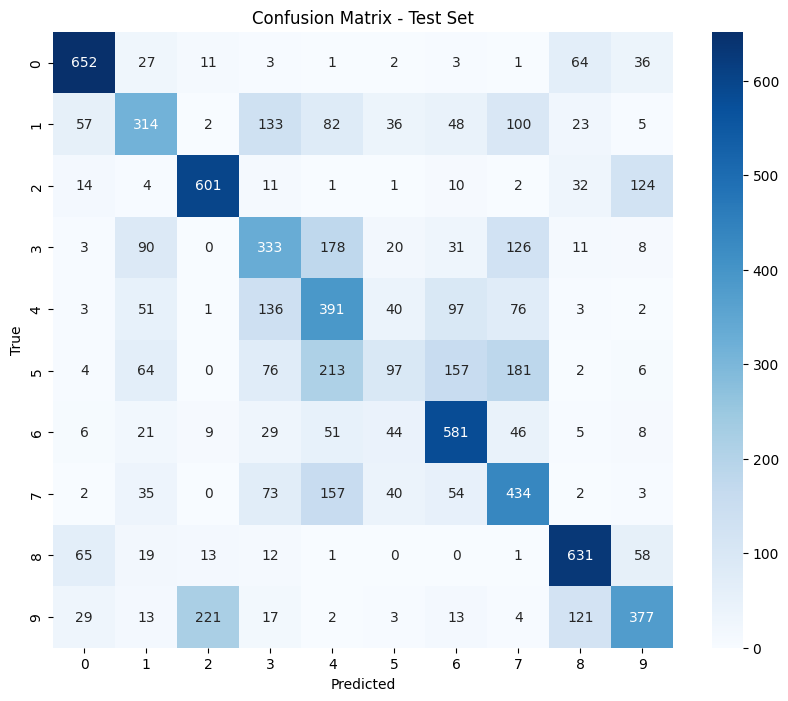

In [0]:
# ============================================================
# Evaluate the trained CNN on the test set and visualize results
# Metrics: accuracy, confusion matrix heatmap
# ============================================================

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from src.model import SimpleCNN
from src.data import get_dataloaders

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataloaders
DATA_DIR = "/home/sagemaker-user/mle-deep-learning-project/data/raw/stl10"
_, _, test_loader = get_dataloaders(data_dir=DATA_DIR, batch_size=64)

# Initialize model and load best checkpoint
model = SimpleCNN(num_classes=10).to(device)
model.load_state_dict(torch.load("/home/sagemaker-user/mle-deep-learning-project/models/best_model.pt", map_location=device))
model.eval()

# Evaluate
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [0]:
# ============================================================
# Log test metrics and confusion matrix plot to MLflow
# ============================================================

import mlflow
import os

# MLflow experiment
experiment_name = "stl10_cnn_experiment"
mlflow.set_experiment(experiment_name)

# Create a folder for artifacts if needed
artifact_dir = "/home/sagemaker-user/mle-deep-learning-project/mlruns/artifacts"
os.makedirs(artifact_dir, exist_ok=True)

# Start MLflow run
with mlflow.start_run(run_name="test_evaluation"):
    # Log test accuracy
    mlflow.log_metric("test_accuracy", acc)
    
    # Save confusion matrix plot
    cm_path = os.path.join(artifact_dir, "confusion_matrix.png")
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(cm_path)
    plt.close()
    
    # Log artifact (plot)
    mlflow.log_artifact(cm_path)

print("Test metrics and confusion matrix saved to MLflow ✅")


Test metrics and confusion matrix saved to MLflow ✅


In [0]:
# ============================================================
# Create a .gitignore for the deep learning project
# ============================================================

gitignore_content = """
# Ignore raw datasets
data/raw/
data/processed/*.csv

# Ignore model checkpoints (optional: keep small ones)
models/*.pt
models/*.pth

# Ignore Python cache
__pycache__/
*.pyc

# Ignore Jupyter notebook checkpoints
.ipynb_checkpoints/

# Ignore MLflow local runs
mlruns/

# OS files
.DS_Store
Thumbs.db
"""

path = "/home/sagemaker-user/mle-deep-learning-project/.gitignore"
with open(path, "w") as f:
    f.write(gitignore_content)

print(".gitignore created successfully ✅")


.gitignore created successfully ✅


In [0]:
import subprocess
import os

PROJECT_DIR = "/home/sagemaker-user/mle-deep-learning-project"
os.chdir(PROJECT_DIR)

# List folders to ensure are tracked
folders = ["data/raw", "data/processed", "models"]
for f in folders:
    path = os.path.join(PROJECT_DIR, f)
    if not os.listdir(path):
        keep_file = os.path.join(path, ".gitkeep")
        open(keep_file, "w").close()
        print(f"✅ Added .gitkeep to {f}")

# Add all files
subprocess.run(["git", "add", "."], check=True)

# Commit
try:
    subprocess.run(["git", "commit", "-m", "Update project structure with empty folders"], check=True)
except subprocess.CalledProcessError:
    print("⚠️ Nothing to commit, skipping commit step")

# Push
subprocess.run(["git", "push", "-u", "origin", "main"], check=True)
print("✅ Folders pushed successfully!")


✅ Added .gitkeep to data/processed
[main e1413b2] Update project structure with empty folders
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 data/processed/.gitkeep


branch 'main' set up to track 'origin/main'.
✅ Folders pushed successfully!


To github.com:Javier-DataScience/cnn-image-classifier-aws.git
   21f861b..e1413b2  main -> main


In [0]:
# ============================================================
# Fix SSH host verification and push to GitHub
# ============================================================

import subprocess
import os

# Project root
PROJECT_DIR = "/home/sagemaker-user/mle-deep-learning-project"
os.chdir(PROJECT_DIR)
print(f"Current directory: {os.getcwd()}")

# ----------------------------
# GitHub repo via SSH
# ----------------------------
GITHUB_USERNAME = "Javier-DataScience"
REPO_NAME = "cnn-image-classifier-aws"
SSH_REMOTE = f"git@github.com:{GITHUB_USERNAME}/{REPO_NAME}.git"

# ----------------------------
# Add GitHub to known_hosts
# ----------------------------
subprocess.run(["ssh-keyscan", "github.com"], stdout=open(os.path.expanduser("~/.ssh/known_hosts"), "a"), check=True)
print("✅ GitHub added to known_hosts")

# ----------------------------
# Configure Git user
# ----------------------------
subprocess.run(["git", "config", "--global", "user.name", GITHUB_USERNAME], check=True)
subprocess.run(["git", "config", "--global", "user.email", "alvaro.vega.vargas@gmail.com"], check=True)
print("✅ Git user identity configured")

# ----------------------------
# Initialize git repo (ignore if exists)
# ----------------------------
subprocess.run(["git", "init"], check=True)

# ----------------------------
# Set SSH remote
# ----------------------------
subprocess.run(["git", "remote", "remove", "origin"], check=False)
subprocess.run(["git", "remote", "add", "origin", SSH_REMOTE], check=True)
print(f"✅ Remote set to {SSH_REMOTE}")

# ----------------------------
# Add all files
# ----------------------------
subprocess.run(["git", "add", "."], check=True)

# ----------------------------
# Commit if there are changes
# ----------------------------
try:
    subprocess.run(
        ["git", "commit", "-m", "Add portfolio-ready CNN image classification project with MLflow"],
        check=True
    )
except subprocess.CalledProcessError:
    print("⚠️ Nothing to commit, skipping commit step")

# ----------------------------
# Rename branch to main
# ----------------------------
subprocess.run(["git", "branch", "-M", "main"], check=True)

# ----------------------------
# Push to GitHub
# ----------------------------
subprocess.run(["git", "push", "-u", "origin", "main"], check=True)

print("✅ Project pushed to GitHub successfully via SSH!")


Current directory: /home/sagemaker-user/mle-deep-learning-project


# github.com:22 SSH-2.0-9a6e115
# github.com:22 SSH-2.0-9a6e115


# github.com:22 SSH-2.0-9a6e115
# github.com:22 SSH-2.0-9a6e115
# github.com:22 SSH-2.0-9a6e115


✅ GitHub added to known_hosts
✅ Git user identity configured
Reinitialized existing Git repository in /home/sagemaker-user/mle-deep-learning-project/.git/
✅ Remote set to git@github.com:Javier-DataScience/cnn-image-classifier-aws.git
On branch main
nothing to commit, working tree clean
⚠️ Nothing to commit, skipping commit step


branch 'main' set up to track 'origin/main'.
✅ Project pushed to GitHub successfully via SSH!


Everything up-to-date


In [0]:
# ============================================================
# Create professional README.md in ONE notebook cell
# ============================================================

with open("README.md", "w") as f:
    f.write("""# CNN Image Classifier - AWS SageMaker

This is a **portfolio-ready image classification project** demonstrating end-to-end deep learning workflow using AWS SageMaker and MLflow.

## Project Overview

- **Goal:** Train a Convolutional Neural Network (CNN) to classify images from the STL10 dataset.
- **Technologies:** PyTorch, MLflow, AWS SageMaker Studio
- **Key Features:**
  - GPU-enabled training
  - Early stopping and learning rate scheduling
  - MLflow experiment tracking (parameters, metrics, artifacts, model versions)
  - Modular project structure with reusable scripts (`src/`)

## Dataset

- **STL10 dataset** (10 classes, 5,000 training images, 8,000 test images)
- Dataset is **not included** due to size; download instructions: [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/)
- Folder structure:
  - `data/raw/`       # Raw dataset (download manually)
  - `data/processed/` # Preprocessed dataset for training

## Project Structure

- `notebooks/`      # Exploratory analysis, training, evaluation
- `src/`            # Reusable scripts (data.py, model.py, train.py)
- `models/`         # Saved model checkpoints (large files not in repo)
- `mlruns/`         # MLflow logs (tracked locally, not in GitHub)
- `README.md`
- `.gitignore`

## Usage

1. Clone the repository
git clone git@github.com
:Javier-DataScience/cnn-image-classifier-aws.git
cd cnn-image-classifier-aws
2. Download the dataset and place it in `data/raw/`
3. Open notebooks in SageMaker Studio to run training, evaluation, and MLflow tracking

## Notes

- Large files like `models/` and `mlruns/` are **not pushed** to GitHub.
- You can view MLflow experiments locally in SageMaker Studio.
""")

print("✅ README.md created successfully in one cell!")


✅ README.md created successfully in one cell!


In [0]:
# ============================================================
# Add, commit, and push updates to GitHub in ONE cell
# ============================================================

import subprocess
import os

PROJECT_DIR = "/home/sagemaker-user/mle-deep-learning-project"
os.chdir(PROJECT_DIR)

# Add all changes
subprocess.run(["git", "add", "."], check=True)

# Commit changes
try:
    subprocess.run(["git", "commit", "-m", "Update README.md and project files"], check=True)
except subprocess.CalledProcessError:
    print("⚠️ Nothing to commit, skipping commit step")

# Push to GitHub via SSH
subprocess.run(["git", "push", "-u", "origin", "main"], check=True)

print("✅ Updates pushed to GitHub successfully!")


[main f60435a] Update README.md and project files
 1 file changed, 44 insertions(+)
 create mode 100644 README.md


branch 'main' set up to track 'origin/main'.
✅ Updates pushed to GitHub successfully!


To github.com:Javier-DataScience/cnn-image-classifier-aws.git
   e1413b2..f60435a  main -> main


## Shutdown cells

In [0]:
"""
Stop spark session and associated Athena Spark session
"""

from IPython import get_ipython as _get_ipython
_get_ipython().user_ns["spark"].stop()